# Instacart Market Basket Analysis

Kaggle data 출처[[링크]](https://www.kaggle.com/competitions/instacart-market-basket-analysis/overview)

In [1]:
import pandas as pd
import numpy as np

* 모든 테이블을 merge하고 downcast한 테이블 불러오기

In [2]:
df = pd.read_parquet("data/instacart/df.parquet.gzip")
df.shape

(33894106, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33894106 entries, 0 to 33894105
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            uint8   
 4   order_dow               uint8   
 5   order_hour_of_day       uint8   
 6   days_since_prior_order  float32 
 7   product_id              float32 
 8   add_to_cart_order       float32 
 9   reordered               float32 
 10  product_name            category
 11  aisle_id                float32 
 12  department_id           float32 
 13  department              category
 14  aisle                   category
dtypes: category(4), float32(6), int64(2), uint8(3)
memory usage: 1.6 GB


* 결측치 확인

In [4]:
df.isnull().sum()

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_id                  75000
add_to_cart_order           75000
reordered                   75000
product_name                75000
aisle_id                    75000
department_id               75000
department                  75000
aisle                       75000
dtype: int64

* days_since_prior_order의 경우 prior data에만 존재하고, 이전 주문이 없는 경우로 예상됨

In [5]:
df[df["days_since_prior_order"].isnull()]["eval_set"].value_counts()

prior    2078068
test           0
train          0
Name: eval_set, dtype: int64

* 나머지 결측치의 경우 test data와 동일한 수이므로, 예측해야할 정보들임

In [6]:
(df["eval_set"] == "prior").sum(), (df["eval_set"] == "train").sum(), (df["eval_set"] == "test").sum()

(32434489, 1384617, 75000)

* 데이터셋의 특성상 모든 숫자가 카테고리형태이므로, int형으로 바꾸되, nan 데이터는 -1로 대체

In [7]:
df[df.select_dtypes("number").columns] = df.select_dtypes("number").fillna(-1).astype(int).copy()

In [8]:
df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2539329,1,prior,1,2,8,-1,196,1,0,Soda,77,7,beverages,soft drinks
1,2539329,1,prior,1,2,8,-1,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree
2,2539329,1,prior,1,2,8,-1,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky
3,2539329,1,prior,1,2,8,-1,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky
4,2539329,1,prior,1,2,8,-1,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods


* 예측해야할 데이터는 order_id별 products id를 열거한 string임을 확인

In [9]:
submit =  pd.read_csv("data/instacart/sample_submission.csv")
submit.head(2)

,order_id,products
0,17,39276 29259
1,34,39276 29259


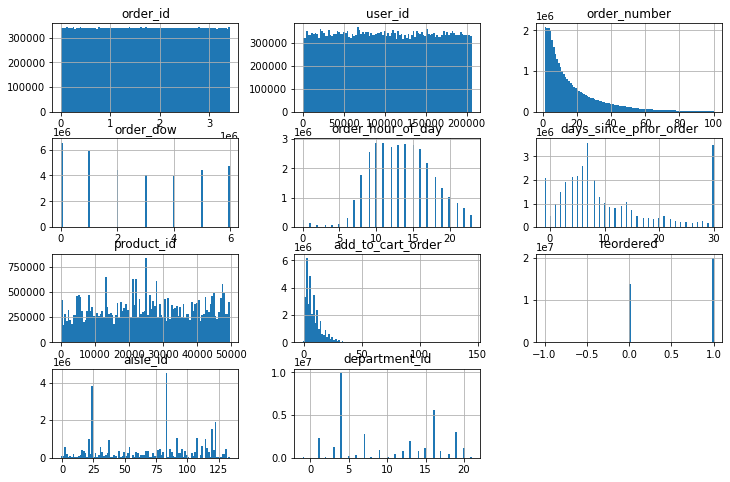

In [10]:
_ = df.hist(bins = 100, figsize = (12, 8))

* train과 test의 `user_id`는 모두 prior에 포함됨

In [11]:
prior_users = df.loc[df['eval_set'] == 'prior', "user_id"]
train_users = df.loc[df['eval_set'] == 'train', "user_id"]
test_users = df.loc[df['eval_set'] == 'test', "user_id"]

In [12]:
all(train_users.isin(prior_users.unique())), all(test_users.isin(prior_users.unique()))

(True, True)

# 전략
* train과 test에 모두 존재하는 컬럼(`order_number, order_dow, order_hour_of_day, days_since_prior_order`)은 feature engineering을 통해 모델 학습에 도움이 되는 방향으로 처리.
* user_id별로 각 feature들과 연결하여 새로운 feature를 추출.

* order_number의 경우 큰 의미가 없을 것으로 예상하여 제외

* `order_dow`을 활용해 주말 여부를 처리

In [13]:
df["weekend"] = (df["order_dow"] < 2).astype(int)
df["weekend"].value_counts()

0    21461811
1    12432295
Name: weekend, dtype: int64

* `order_hour_of_day`를 구매시간을 하루 기준 8시간식 3등분함

<AxesSubplot:>

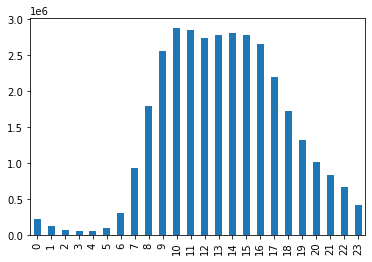

In [14]:
df["order_hour_of_day"].value_counts().sort_index().plot.bar()

<AxesSubplot:>

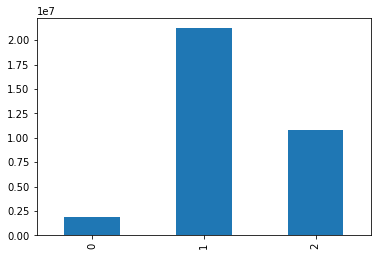

In [15]:
def label_hours(hour):
    if hour < 8:
        label_hour = 0
    elif 8 <= hour < 16:
        label_hour = 1
    else:
        label_hour = 2
    return label_hour

df["hour_labeled"] = df["order_hour_of_day"].map(label_hours)
df["hour_labeled"].value_counts().sort_index().plot.bar()

* `days_since_prior_order`의 경우, -1(nan에서 변환)은 첫주문이고, 30의 경우 최대치로 그 이상의 날짜들을 모두 포함하고 있는 것으로 보임
* -1과 30을 제외한 날짜들을 10일 단위로 binning해주고, 첫주문과 30일 이상의 경우 별도의 그룹으로 처리

<AxesSubplot:>

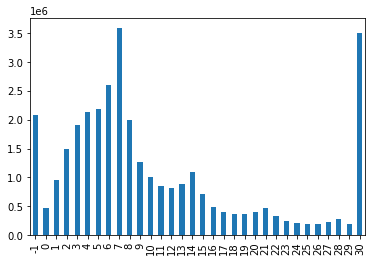

In [16]:
df["days_since_prior_order"].value_counts().sort_index().plot.bar()

In [17]:
def binning_day_since_prior_order(day: int):
    if day == -1:
        binned_level = 0
    else:
        binned_level = day//10 + 1
    return binned_level

In [18]:
df["prior_order_cut"] = df["days_since_prior_order"].map(binning_day_since_prior_order).astype("category")
df[["days_since_prior_order", "prior_order_cut"]].sample(5)

,days_since_prior_order,prior_order_cut
24654496,27,3
24244088,28,3
28053956,8,1
14788244,7,1
28382271,7,1


<AxesSubplot:>

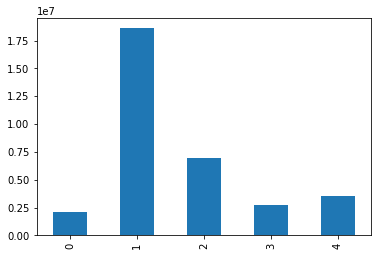

In [19]:
df["prior_order_cut"].value_counts().sort_index().plot.bar()

* 데이터 셋 접근을 용이하게 하기 위해 eval_set에 따라 분리

In [20]:
df_prior = df[df["eval_set"] == "prior"].copy()

In [21]:
df_train = df[df["eval_set"] == "train"].copy()

In [22]:
df_test = df[df["eval_set"] == "test"].copy()

In [23]:
del df

In [ ]:
reorder_cnt = df_prior.groupby(['user_id', "prior_order_cut", "hour_labeled"])['product_id'].value_counts().rename("reorder_cnt").reset_index()

In [ ]:
reorder_cnt = df_prior.groupby(['user_id', 'product_id', "prior_order_cut", "hour_labeled"])['order_id'].count().rename("reorder_cnt").reset_index()

In [30]:
reorder_cnt

,user_id,prior_order_cut,hour_labeled,product_id,reorder_cnt
0,1,0,1,196,1
1,1,0,1,12427,1
2,1,0,1,14084,1
3,1,0,1,26088,1
4,1,0,1,26405,1
...,...,...,...,...,...
21944994,206209,4,1,40534,1
21944995,206209,4,1,40992,1
21944996,206209,4,1,41665,1
21944997,206209,4,1,43961,1


In [32]:
feature_names = ["user_id", "hour_labeled", "prior_order_cut", "product_id", "reorder_cnt"]

In [33]:
df_train_merged = reorder_cnt.loc[reorder_cnt["user_id"].isin(train_users.unique())].merge(
    df_train[["user_id", "eval_set", "hour_labeled", "prior_order_cut", "product_id"]], how = "left")

In [34]:
df_train_merged.head()

,user_id,prior_order_cut,hour_labeled,product_id,reorder_cnt,eval_set
0,1,0,1,196,1,NaN
1,1,0,1,12427,1,NaN
2,1,0,1,14084,1,NaN
3,1,0,1,26088,1,NaN
4,1,0,1,26405,1,NaN


In [35]:
df_train_merged["label"] = df_train_merged["eval_set"].notnull().astype(int)

In [36]:
df_train_merged["label"].value_counts()

0    13603292
1      376283
Name: label, dtype: int64

In [37]:
df_test_merged = reorder_cnt.loc[reorder_cnt["user_id"].isin(test_users.unique())].merge(
    df_test[["user_id", "eval_set", "hour_labeled", "prior_order_cut", "product_id"]], how = "left")

In [38]:
df_test_merged.head()

,user_id,prior_order_cut,hour_labeled,product_id,reorder_cnt,eval_set
0,3,0,1,9387,1,NaN
1,3,0,1,15143,1,NaN
2,3,0,1,16797,1,NaN
3,3,0,1,17668,1,NaN
4,3,0,1,21903,1,NaN


In [39]:
df_test_merged["label"] = df_test_merged["eval_set"].notnull().astype(int)

In [40]:
df_test_merged["label"].value_counts()

0    7965424
Name: label, dtype: int64

In [41]:
X_train = df_train_merged[feature_names].astype(int)
X_test = df_test_merged[feature_names].astype(int)
y_train = df_train_merged['label']
y_test = df_test_merged['label']

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13979575, 5), (7965424, 5), (13979575,), (7965424,))

In [43]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators = 10, n_jobs = -1, verbosity = 1, random_state = 42)

/Users/jihong/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [44]:
clf.fit(X_train, y_train)

/Users/jihong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/jihong/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:12:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=1)

In [45]:
y_fitted = clf.predict(X_train)

In [46]:
(y_train == y_fitted).mean()

0.9730867354694259

In [47]:
y_predict = clf.predict(X_test)

In [48]:
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
result = X_test.copy()
result["prediction"] = y_predict

In [50]:
result

,user_id,hour_labeled,prior_order_cut,product_id,reorder_cnt,prediction
0,3,1,0,9387,1,0
1,3,1,0,15143,1,0
2,3,1,0,16797,1,0
3,3,1,0,17668,1,0
4,3,1,0,21903,1,0
...,...,...,...,...,...,...
7965419,206208,2,3,27608,1,0
7965420,206208,2,3,28986,1,0
7965421,206208,2,3,34213,1,0
7965422,206208,2,3,46069,1,0


In [51]:
result["product_id"] = result["product_id"].astype(str)

In [62]:
products = result[result["prediction"] != 0].groupby("user_id").agg({"product_id" : lambda x : ' '.join(x)}).reset_index()
products

,user_id,product_id
0,42990,16083 35951
1,84478,31981
2,196622,28226
3,197263,43352
4,197300,4945 4945 27845
5,197431,9839
6,197551,34126 39877 21903 28601 31717
7,197640,329 46650 21137 16185
8,197668,13176
9,197957,39180


In [64]:
result_products = df_test[['order_id', 'user_id']].merge(products, on = "user_id")
result_products

,order_id,user_id,product_id
0,1235859,42990,16083 35951
1,2503149,84478,31981
2,748532,196622,28226
3,406983,197263,43352
4,3221182,197300,4945 4945 27845
5,897278,197431,9839
6,2166711,197551,34126 39877 21903 28601 31717
7,997972,197640,329 46650 21137 16185
8,2961298,197668,13176
9,2821910,197957,39180


In [75]:
df_submit = submit.merge(result_products, how = 'left').drop(columns = ["products", "user_id"]).rename(columns = {"product_id": "products"}).fillna("None")
df_submit

,order_id,products
0,17,None
1,34,None
2,137,None
3,182,None
4,257,None
...,...,...
74995,3420740,None
74996,3420877,None
74997,3420888,None
74998,3420989,None


In [76]:
df_submit.to_csv("data/submit.csv", index = False)

## 느낀 점

기존과는 달리 여러 개의 테이블을 합치고, 엄청 나게 큰 데이터셋을 분석하려니, 분석에 힘도 많이 들고, 막막한 마음이 많이 드는 프로젝트였다.처음에는 맨땅에 부딪히듯 분석해보고, 감이 안올 때는 다른 사람들의 노트북을 참고하게 되었다. 최종적으로 만들어진 모델이 전혀 예측하지 못하는 것 같아서 조금 슬픈 감정도 들었다. 이제 어떻게 분석하면 좋을지 감이 올때 쯤 되어 프로젝트를 마무리해야해서 조금 아쉽긴 하지만, 좋은 경험이었던 것 같다.